In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from ydata_profiling import ProfileReport
from pathlib import Path

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)

#read config file
config_path = "../configs/configs.yaml"

with open(config_path,"r") as f:
    config = yaml.safe_load(f)

data_path = Path(config["raw_data_path"])
target_col = config["target"]

print(f"Config loaded successfully!")
print(f"Data path: {data_path}")
print(f"Target column:{target_col}")

#3. Load data
df = pd.read_csv(data_path, parse_dates=["TIMESTAMP"])
print(f"Data loaded successfully! Shape = {df.shape}")
df.head()

/opt/miniconda3/envs/wind/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Config loaded successfully!
Data path: ../data/processed/gefcom_wind_all_zones.csv
Target column:TARGETVAR
Data loaded successfully! Shape = (168000, 7)


,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100
0,1,2012-01-01 01:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076
1,1,2012-01-01 02:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761
2,1,2012-01-01 03:00:00,0.110234,2.672210,-0.822516,3.508448,-1.214093
3,1,2012-01-01 04:00:00,0.165116,2.457504,-0.143642,3.215233,-0.355546
4,1,2012-01-01 05:00:00,0.156940,2.245898,0.389576,2.957678,0.332701


In [ ]:
print("\n Data type and missing information:")
print(df.info())

print("\n Descriptive statistics:")
display(df.describe().T)

print("\n missing value statistics:")
print(df.isna().sum())

In [6]:
#basic sanity and per-zone continuity
print(df.dtypes)
print("Unique zones:", df["ZONEID"].nunique(), sorted(df["ZONEID"].unique().tolist()))
#sort and check hourly gaps
df = df.sort_values(["ZONEID", "TIMESTAMP"]).reset_index(drop=True)
gaps = (df.groupby("ZONEID")["TIMESTAMP"]
          .diff().dt.total_seconds().div(3600)
        .fillna(1))
print("Share of non-1h steps:", (gaps != 1).mean())


ZONEID                int64
TIMESTAMP    datetime64[ns]
TARGETVAR           float64
U10                 float64
V10                 float64
U100                float64
V100                float64
dtype: object
Unique zones: 10 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Share of non-1h steps: 0.0


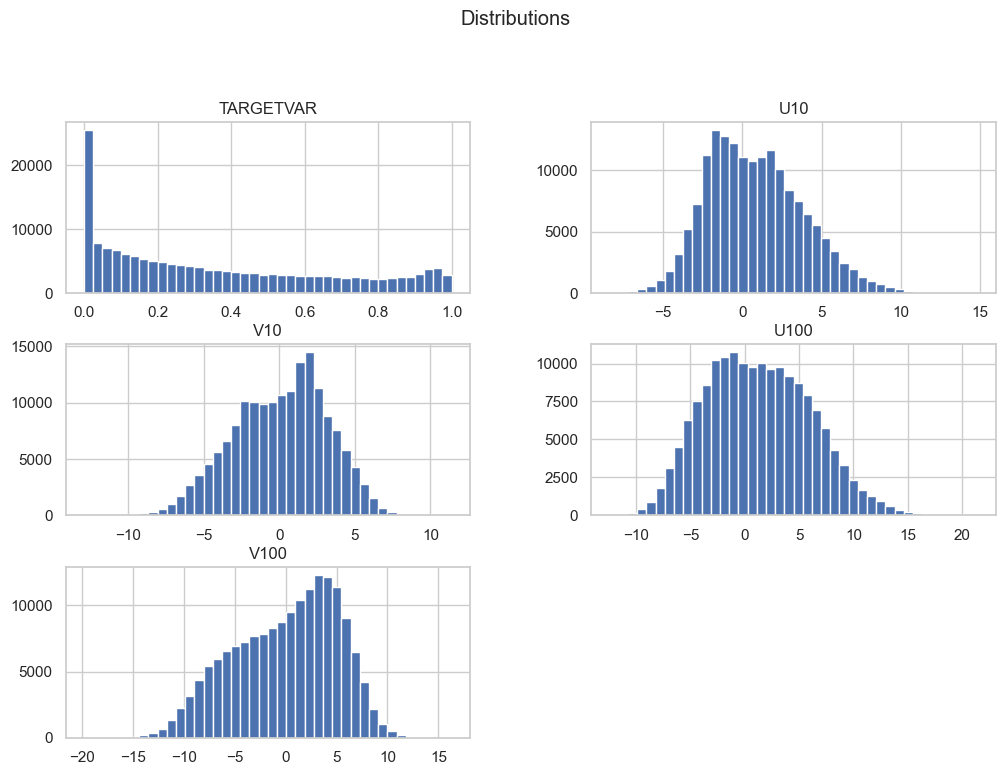

,count,mean,std,min,25%,50%,75%,max
TARGETVAR,167888.0,0.360480,0.310831,0.000000,0.081003,0.281302,0.606016,1.000000
U10,168000.0,0.818764,3.034753,-8.371644,-1.501748,0.545120,2.805488,14.837177
V10,168000.0,0.089091,3.116356,-12.923576,-2.158184,0.363812,2.341910,11.401396
U100,168000.0,1.282886,4.823644,-12.425352,-2.410327,1.056050,4.753575,21.399071
V100,168000.0,0.009308,5.113098,-19.791997,-3.864192,0.709303,4.072244,16.304799


In [10]:
#distributions(target & winds)
num_cols = [target_col, "U10", "V10", "U100", "V100"]
ax = df[num_cols].hist(bins=40, figsize=(12,8))
plt.suptitle("Distributions", y=1.02)
plt.show()

df[num_cols].describe().T

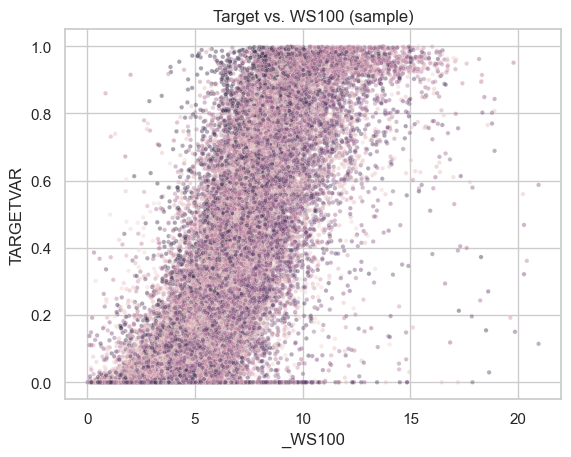

,_WS10,_WS100,TARGETVAR
_WS10,1.000000,0.917451,0.711410
_WS100,0.917451,1.000000,0.764711
TARGETVAR,0.711410,0.764711,1.000000


In [ ]:
#temporary analysis features
df["_WS10"] = np.hypot(df["U10"], df["V10"])
df["_WS100"] = np.hypot(df["U100"], df["V100"])

sns.scatterplot(data=df.sample(min(len(df), 30000), random_state = 0),
                x="_WS100", y=target_col, hue="ZONEID", s=10, alpha=0.4, legend=False)
plt.title("Target vs. WS100 (sample)")
plt.show()

df[["_WS10", "_WS100", target_col]].corr(numeric_only=True)

In [ ]:
#seasonality(hour/month)
tmp = df.assign(
    hour=df["TIMESTAMP"].dt.hour,
    month=df["TIMESTAMP"].dt.month
)

hourly = tmp.groupby(["ZONEID", "hour"])[target_col].mean().reset_index()
sns.lineplot(data=hourly, x="hour", y=target_col, hue="ZONEID")
plt.title("Mean Target by Hour")
plt.show()

monthly = tmp.groupby(["ZONEID", "month"])[target_col].mean().reset_index()
sns.lineplot(data=monthly, x="month", y=target_col, hue="ZONEID")
plt.title("Mean Target by Month")
plt.show()

In [ ]:
#missing rates
miss = df.isna().mean().sort_values(ascending=False)
print("Missing rate:\n", miss)

#IQR outlier flag
def iqr_outlier(s, k=1.5)                                    

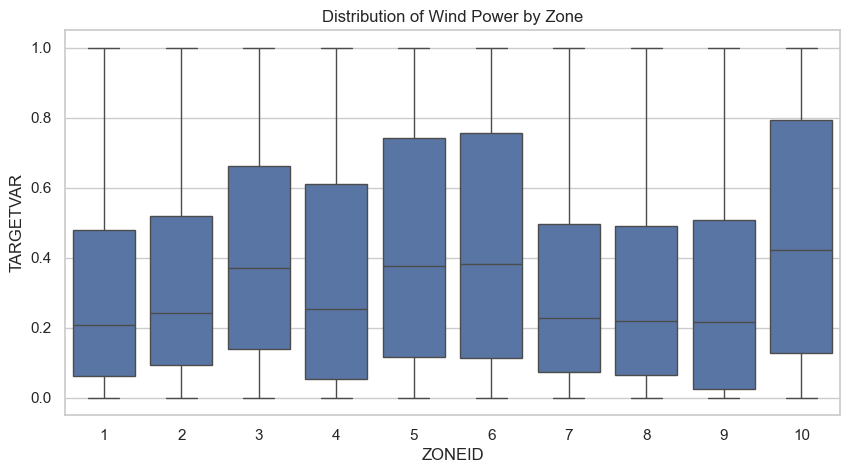

In [12]:
#zone distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x="ZONEID", y=target_col, data=df)
plt.title("Distribution of Wind Power by Zone")
plt.show()

In [ ]:
#time trend(zone 1)
zone_1 = df[df["ZONEID"] == 1]
plt.figure(figsize=(12,4))
plt.plot(zone_1["TIMESTAMP"], zone_1[target_col], linewidth=0.7)
plt.title("Wind Power Over Time (Zone 1)")
plt.xlabel("Time")
plt.ylabel("Power")
plt.show()

In [ ]:
#correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="Blues")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
#generate HTML profiling report
profile = ProfileReport(df, title="Wind Forecast EDA Report", explorative=True)
profile.to_file("../notebooks/EDA_report.html")

print("HTML EDA report saved to notebooks/EDA_report.html")